In [1]:
#initial instalation
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.0 MB/s eta 0:00:00


In [2]:
#Dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.functional import softmax
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import classification_report

In [3]:
#Load the Data
from google.colab import files

uploaded = files.upload()

Saving Emotion_classify_Data.csv to Emotion_classify_Data.csv


In [4]:
# Read file
import io
sent_prediction_df = pd.read_csv(io.BytesIO(uploaded['Emotion_classify_Data.csv']))

sentiment_prediction_df = sent_prediction_df.copy()

In [5]:
#Display DF
sentiment_prediction_df.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


 ## Step 1: fine-tunes a pre-trained BERT model on a sentiment analysis task using the specified dataset and hyperparameters. The trained model is then saved for future use.

In [6]:
# Load the BERT tokenizer and pre-trained model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)



# Convert the DataFrame to a list of dictionaries
dataset = sentiment_prediction_df.to_dict(orient="records")

# Define a mapping from emotion strings to integers
emotion_mapping = {'fear': 0, 'joy': 1, 'anger': 2}

# Convert emotion strings to integers in the dataset
for item in dataset:
    item['Emotion'] = emotion_mapping[item['Emotion']]

# Tokenize the dataset
inputs = tokenizer([item['Comment'] for item in dataset], padding=True, truncation=True, return_tensors='pt')
labels = torch.tensor([item['Emotion'] for item in dataset])

# Create a PyTorch DataLoader
dataset = TensorDataset(inputs.input_ids, inputs.attention_mask, labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)



# Specify hyperparameters
learning_rate = 2e-5
epochs = 6
total_steps = len(train_dataloader) * epochs

# Create the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_loss_all = []



# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    print('start training epoch', epoch, ' of ', epochs)
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss for epoch {epoch}: {avg_train_loss}")
    train_loss_all.append(avg_train_loss)

# Evaluate the model on the test data
# Save the trained model
model.save_pretrained("sentiment_model")




(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)base-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


start training epoch 0  of  6
Average training loss for epoch 0: 0.35838334455534265
start training epoch 1  of  6
Average training loss for epoch 1: 0.07707080593911197
start training epoch 2  of  6
Average training loss for epoch 2: 0.030679168250577944
start training epoch 3  of  6
Average training loss for epoch 3: 0.019047613961325004
start training epoch 4  of  6
Average training loss for epoch 4: 0.01402004078984643
start training epoch 5  of  6
Average training loss for epoch 5: 0.008408003556561697


###Step 2: Evaluate the previously trained sentiment analysis model on a test dataset. provides insights into the model's performance on the test dataset, including the average loss and accuracy. It's a crucial step to assess how well the model generalizes to unseen data.

In [17]:
#Set the model to evaluation mode
model.eval()

#Variable to hold the counts of correct prediction, test loss, and total
test_loss = 0
correct = 0
total = 0

#Create a list to hold predicted and ground truth
predicted = []
gt = []

#Using torch.no_grad() to disable gradient computation during inference
with torch.no_grad():
   #Iterate through batches in the test dataloader
    for batch in test_dataloader:

       #Move batch to the specified device
        batch = tuple(t.to(device) for t in batch)

        # Prepare inputs for the model
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}

        #Forward pass through the model
        outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits

         # Accumulate test loss
        test_loss += loss.item()

        #Calculate predictions using argmax on the softmax output
        preds = torch.argmax(softmax(logits, dim=1), dim=1)
        labels = inputs["labels"]

        #Extend lists to store predicted and ground truth labels
        predicted.extend(preds.cpu().numpy())
        gt.extend(labels.cpu().numpy())

        #Update correctness count
        correct += (preds == labels).sum().item()

        #Update total count
        total += labels.size(0)

#calculation of total loss and acuracy
avg_test_loss = test_loss / len(test_dataloader)
accuracy = correct / total

print(f"Average test loss: {avg_test_loss}")
print(f"Test accuracy: {accuracy}")



Average test loss: 0.12974765985964284
Test accuracy: 0.9671717171717171


In [8]:
len(train_loss_all)

6

##Step 3: Visualization, Heatmap of Confusion Matrix and Classification Report

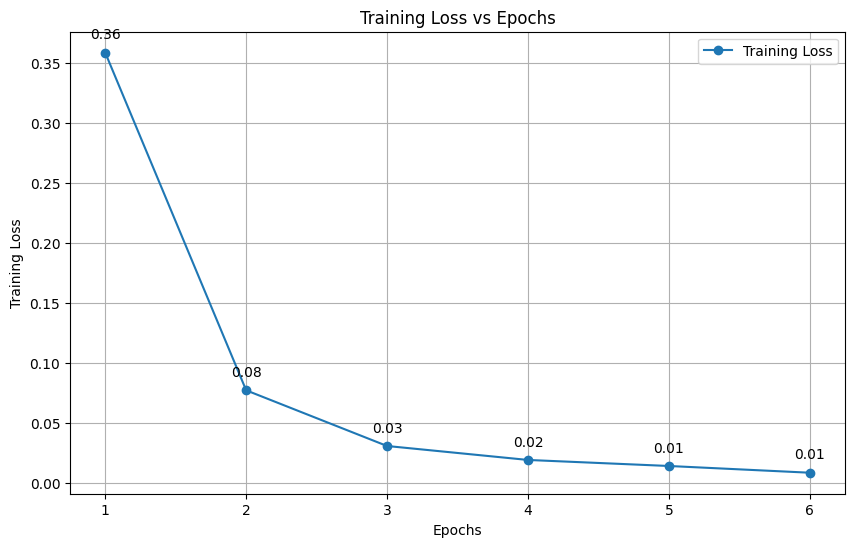

In [9]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_loss_all, label='Training Loss', marker='o')
# plt.plot(range(1, epochs + 1), validation_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
# Annotate data points with their training loss values
for i, loss in enumerate(train_loss_all):
    plt.annotate(f'{loss:.2f}', (i + 1, loss), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()






In [10]:
labels = ['fear', 'joy', 'anger']

label_mapping = {0:'fear', 1:'joy', 2:'anger'}

# Convert emotion strings to integers in the dataset
gt_label = [ label_mapping[item] for item in gt]
predicted_label = [ label_mapping[item] for item in predicted]


cf = confusion_matrix(gt_label,predicted_label, labels = labels )

In [11]:
cf

array([[359,   2,  13],
       [  3, 406,   5],
       [ 13,   3, 384]])

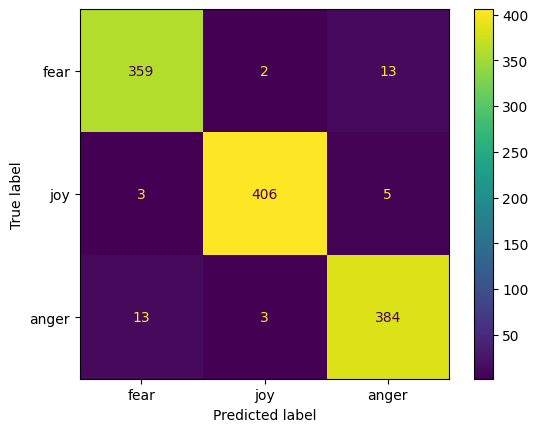

In [12]:
#Plot the confusion matrix
ConfusionMatrixDisplay(cf, display_labels=labels, ).plot()

In [13]:
#Classification Report
print(classification_report(gt_label, predicted_label, target_names=labels))

              precision    recall  f1-score   support

        fear       0.96      0.96      0.96       400
         joy       0.96      0.96      0.96       374
       anger       0.99      0.98      0.98       414

    accuracy                           0.97      1188
   macro avg       0.97      0.97      0.97      1188
weighted avg       0.97      0.97      0.97      1188

